# Imports

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Function Definitions

## Rotation Matrices

In [2]:
def xRot(theta):
    angle = math.radians(theta)
    mat = np.array([[1, 0, 0],
                   [0, math.cos(angle), math.sin(angle)],
                   [0, -math.sin(angle), math.cos(angle)]])
    return mat

In [3]:
def yRot(theta):
    angle = math.radians(theta)
    mat = np.array([[math.cos(angle), 0, math.sin(angle)],
                   [0, 1, 0],
                   [-math.sin(angle), 0, math.cos(angle)]])
    return mat

In [4]:
def zRot(theta):
    angle = math.radians(theta)
    mat = np.array([[math.cos(angle), math.sin(angle), 0],
                   [-math.sin(angle), math.cos(angle), 0],
                   [0, 0, 1]])
    return mat

## Body Functions

In [46]:
def bodyPos(pitch = 0, roll = 0, yaw = 0, Tx = 0, Ty = 0, Tz = 0):
    body_rot = np.matmul(zRot(yaw), yRot(roll))
    body_rot = np.matmul(body_rot, xRot(pitch));
    
    body_0 = np.matmul(inv(body_rot), np.array([[body_offset / 2, body_offset * math.sin(math.pi / 3), 0]]).T);
    body_1 = np.matmul(inv(body_rot), np.array([[body_offset, 0, 0]]).T);
    body_2 = np.matmul(inv(body_rot), np.array([[body_offset / 2, -body_offset * math.sin(math.pi / 3), 0]]).T);
    body_3 = np.matmul(inv(body_rot), np.array([[-body_offset / 2, -body_offset * math.sin(math.pi / 3), 0]]).T);
    body_4 = np.matmul(inv(body_rot), np.array([[-body_offset, 0, 0]]).T);
    body_5 = np.matmul(inv(body_rot), np.array([[-body_offset / 2, body_offset * math.sin(math.pi / 3), 0]]).T);
    
    body_model = np.concatenate((body_0.T, body_1.T, body_2.T, body_3.T, body_4.T, body_5.T, body_0.T), axis = 0)
    translation = [[Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz],
    [Tx, Ty, Tz]]
    
    body_model = body_model + translation
    
    return body_model

## Leg Functions

In [47]:
def legPos(coax_angle, femur_angle, tibia_angle, body_model, leg_num):
    coax_rot = zRot(coax_angle)
    femur_rot = np.matmul(yRot(femur_angle), coax_rot)
    tibia_rot = np.matmul(yRot(tibia_angle), femur_rot)
    
    leg_coax = np.matmul(inv(coax_rot), np.array([[coax, 0, 0]]).T) + np.array([body_model[leg_num, :]]).T
    leg_femur = np.matmul(inv(femur_rot), np.array([[femur, 0, 0]]).T) + leg_coax
    leg_tibia = np.matmul(inv(tibia_rot), np.array([[0, 0, -tibia]]).T) + leg_femur
                       
    leg_model = np.concatenate((np.array([body_model[leg_num, :]]), leg_coax.T, leg_femur.T, leg_tibia.T), axis = 0)
    return leg_model

In [48]:
def legAngle(x, y, z):
    coax_angle = math.degrees(math.atan2(y, x));
    coax_rot = zRot(-coax_angle)
    leg_rotated = np.matmul(inv(coax_rot), np.array([[x, y, z]]).T)
    femur_angle = math.degrees(math.acos((tibia ** 2 - femur ** 2 - leg_rotated[2] ** 2 - (leg_rotated[0] - coax) ** 2) / (-2 * femur * (math.sqrt(leg_rotated[2] ** 2 + (leg_rotated[0] - coax) ** 2))))) - math.degrees(math.atan2(-leg_rotated[2], (leg_rotated[0] - coax)));
    tibia_angle = math.degrees(math.acos((leg_rotated[2] ** 2 + (leg_rotated[0] - coax) ** 2 - femur ** 2 - tibia ** 2) / (-2 * femur * tibia))) - 90;
    
    if abs(coax_angle) <= 1e-10:
        coax_angle = 0;
        
    if abs(femur_angle) <= 1e-10:
        femur_angle = 0;
    
    if abs(tibia_angle) <= 1e-10:
        tibia_angle = 0;
    
    return [coax_angle, femur_angle, tibia_angle]

## Plot Model

In [49]:
def showModel():
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    # plotting
    ax.plot3D(body_model[:, 0], body_model[:, 1], body_model[:, 2], 'green');
    ax.plot3D(leg0_model[:, 0], leg0_model[:, 1], leg0_model[:, 2], 'blue');
    ax.plot3D(leg1_model[:, 0], leg1_model[:, 1], leg1_model[:, 2], 'blue');
    ax.plot3D(leg2_model[:, 0], leg2_model[:, 1], leg2_model[:, 2], 'blue');
    ax.plot3D(leg3_model[:, 0], leg3_model[:, 1], leg3_model[:, 2], 'blue');
    ax.plot3D(leg4_model[:, 0], leg4_model[:, 1], leg4_model[:, 2], 'blue');
    ax.plot3D(leg5_model[:, 0], leg5_model[:, 1], leg5_model[:, 2], 'blue');
    ax.set_xlim(-200, 200);
    ax.set_ylim(-200, 200);
    ax.set_zlim(-100, 100);

# Hexapod Measurments

In [50]:
body_offset = 85 #mm
coax = 26.34 #mm
femur = 76.2 #mm
tibia = 88.32 #mm

# Body Starting Position

In [51]:
body_model = bodyPos(0, 0, 0, 20, 0, 0);

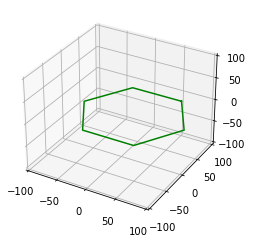

In [52]:
%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection ='3d')
# plotting
ax.plot3D(body_model[:, 0], body_model[:, 1], body_model[:, 2], 'green');
ax.set_xlim(-100, 100);
ax.set_ylim(-100, 100);
ax.set_zlim(-100, 100);

In [53]:
start_radius = 150
start_height = 20
start_leg0 = legAngle(start_radius * math.cos(math.pi / 3) - body_model[0, 0], start_radius * math.sin(math.pi / 3) - body_model[0, 1], - start_height - body_model[0, 2])
start_leg1 = legAngle(start_radius - body_model[1, 0], - body_model[1, 1], - start_height - body_model[1, 2])
start_leg2 = legAngle(start_radius * math.cos(- math.pi / 3) - body_model[2, 0], start_radius * math.sin(- math.pi / 3) - body_model[2, 1], - start_height - body_model[2, 2])
start_leg3 = legAngle(start_radius * math.cos(- 2 * math.pi / 3) - body_model[3, 0], start_radius * math.sin(- 2 * math.pi / 3) - body_model[3, 1], - start_height - body_model[3, 2])
start_leg4 = legAngle(- start_radius + body_model[1, 0], -body_model[4, 1], - start_height - body_model[4, 2])
start_leg5 = legAngle(start_radius * math.cos(2 * math.pi / 3) - body_model[5, 0], start_radius * math.sin(2 * math.pi / 3) - body_model[5, 1], - start_height - body_model[5, 2])

# Leg Starting Positions

In [54]:
leg0_model = legPos(start_leg0[0], start_leg0[1], start_leg0[2], body_model, 0) #coax angle, femur angle, tibia angle, model of the hexapod body, leg number
leg1_model = legPos(start_leg1[0], start_leg1[1], start_leg1[2], body_model, 1)
leg2_model = legPos(start_leg2[0], start_leg2[1], start_leg2[2], body_model, 2)
leg3_model = legPos(start_leg3[0], start_leg3[1], start_leg3[2], body_model, 3)
leg4_model = legPos(start_leg4[0], start_leg4[1], start_leg4[2], body_model, 4)
leg5_model = legPos(start_leg5[0], start_leg5[1], start_leg5[2], body_model, 5)
print(leg0_model[3,:])
print(leg1_model[3,:])
print(leg2_model[3,:])
print(leg3_model[3,:])
print(leg4_model[3,:])
print(leg5_model[3,:])

[ 75.         129.90381057 -20.        ]
[150.   0. -20.]
[  75.         -129.90381057  -20.        ]
[ -75.         -129.90381057  -20.        ]
[-1.1000000e+02 -5.5109106e-15 -2.0000000e+01]
[-75.         129.90381057 -20.        ]


In [55]:
%matplotlib qt

showModel()